In [2]:
import numpy as np
import os
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
# package for io 
from aicsimageio.writers import OmeTiffWriter

import skimage.io
from CustomFunctions.track_functions import segment_nuc_tracks_iSIM, segment_nuc_tracks
import itertools
from skimage import measure as skmeasure
import datetime

# load in some stuff to speed up processing
# (following https://sedeh.github.io/python-pandas-multiprocessing-workaround.html)
import multiprocessing

def collect_results(result):
    """Uses apply_async's callback to setup up a separate Queue for each process.
    This will allow us to collect the results from different threads."""
    results.append(result)
    

def mygrouper(n, iterable):
    args = [iter(iterable)] * n
    return ([e for e in t if e != None] for t in itertools.zip_longest(*args))
    


def get_intensity_features(img, seg):
    features = {}
    input_seg = seg.copy()
    input_seg = (input_seg>0).astype(np.uint8)
    input_seg_lcc = skmeasure.label(input_seg)
    for mask, suffix in zip([input_seg, input_seg_lcc], ['', '_lcc']):
        values = img[mask>0].flatten()
        if values.size:
            features[f'intensity_mean{suffix}'] = values.mean()
            features[f'intensity_std{suffix}'] = values.std()
            features[f'intensity_1pct{suffix}'] = np.percentile(values, 1)
            features[f'intensity_99pct{suffix}'] = np.percentile(values, 99)
            features[f'intensity_max{suffix}'] = values.max()
            features[f'intensity_min{suffix}'] = values.min()
        else:
            features[f'intensity_mean{suffix}'] = np.nan
            features[f'intensity_std{suffix}'] = np.nan
            features[f'intensity_1pct{suffix}'] = np.nan
            features[f'intensity_99pct{suffix}'] = np.nan
            features[f'intensity_max{suffix}'] = np.nan
            features[f'intensity_min{suffix}'] = np.nan
    return features



def dist_f(a1, b1, c1, a2, b2, c2):
     
    d = ( a1 * a2 + b1 * b2 + c1 * c2 )
    e1 = math.sqrt( a1 * a1 + b1 * b1 + c1 * c1)
    e2 = math.sqrt( a2 * a2 + b2 * b2 + c2 * c2)
    d = d / (e1 * e2)
    A = math.degrees(math.acos(d))
    return A


def signed_3D_angle_relative_to_X(Va):
    Vb = np.array([1,0,0])
    cr = np.cross(Va,Vb)
    Vn = cr/np.linalg.norm(cr)
    radians = math.atan2(np.dot(np.cross(Va, Vb), Vn), np.dot(Va, Vb))
    angle = math.degrees(radians)
    if Va[1] < 0:
        angle = -angle
    return angle


def Angular_bias(Va):
    M2 = Va[1]/Va[0]
    angle = math.degrees(math.atan2(Va[1],Va[0]))
    bias = 90 - abs(angle)
    return bias, angle

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def vec_angle(
    vector_1,
    vector_2):
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    degree = math.degrees(angle)
    return degree



In [3]:
############################# RUN TRACKMATE TRACKING ON SEGMENTED IMAGES ##################################

In [4]:
############### open data ########

savedir = 'D:/Aaron/Data/Chemotaxis/Data_/'
fl = 'D:/Aaron/Data/Chemotaxis/Processed_Data/'
cl = [x for x in os.listdir(fl) if 'info' in x]
big = []
for i in cl:
    tmp = pd.read_csv(fl+i)
    big.append(tmp.iloc[0])
df = pd.DataFrame(big)
df['cellid'] = [x.split('_frame')[0] for x in df.cell]


In [5]:
newdf = pd.DataFrame([])
for i, x in df.groupby('cellid'):
    x = x.reset_index(drop = True)
    dif = x[['x','y','z']].diff()
    bias = []
    angle = []
    for r, m in enumerate(x):
        if r == 0:
            bias.append(np.nan)
            angle.append(np.nan)
        else:
            b, a = Angular_bias(dif.iloc[r][['x','y']])
            bias.append(b)
            angle.append(a)
    x['angular_bias'] = bias
    x['angle'] = angle
    newdf = newdf.append(x)
newdf = newdf.reset_index(drop = True)

rando = newdf[newdf['frame']<41].copy()
direct = newdf[newdf['frame']>40].copy()

rando['treatment'] = ['rando']*len(rando)
direct['treatment'] = ['direct']*len(direct)
newest = pd.concat([rando, direct], ignore_index=True)
    
import seaborn as sns

# sns.set_style('whitegrid')
# sns.kdeplot(data = newest, x='angles', hue = 'treatment', common_norm=False)
fig, ax = plt.subplots(figsize=(15, 10))
colors = sns.color_palette("Set2")
colors = list(colors.as_hex())
for i,x in enumerate(newest.treatment.unique()):
    sns.histplot(ax = ax, data=newest[newest.treatment == x], x='angular_bias', bins=21, stat='percent', color = colors[i], kde = True)

plt.legend(labels=newest.treatment.unique())
# plt.show()
# plt.savefig("F:/caged_FITC/Data/20220510_0525_angle_density_plot.png") 

IndexError: single positional indexer is out-of-bounds

In [1]:
################ look at directionality over longer time scales (30 seconds) ##############

newdf = pd.DataFrame([])
for i, x in df.groupby('cellid'):
    x = x.reset_index(drop = True)
    dif = x[['x','y','z']].diff(2)
    bias = []
    angle = []
    for r, m in dif.iterrows():
        if m.isnull().values.any():
            bias.append(np.nan)
            angle.append(np.nan)
        else:
            b, a = Angular_bias(dif.iloc[r][['x','y']])
            bias.append(b)
            angle.append(a)
    x['angular_bias'] = bias
    x['angle'] = angle
    newdf = newdf.append(x)
newdf = newdf.reset_index(drop = True)

rando = newdf[newdf['frame']<41].copy()
direct = newdf[newdf['frame']>40].copy()

rando['treatment'] = ['rando']*len(rando)
direct['treatment'] = ['direct']*len(direct)
newest = pd.concat([rando, direct], ignore_index=True)
    
import seaborn as sns

# sns.set_style('whitegrid')
# sns.kdeplot(data = newest, x='angles', hue = 'treatment', common_norm=False)
fig, ax = plt.subplots(figsize=(10, 5))
colors = sns.color_palette("Set2")
colors = list(colors.as_hex())
for i,x in enumerate(newest.treatment.unique()):
    sns.histplot(ax = ax, data=newest[newest.treatment == x], x='angular_bias', bins=21, stat='percent', color = colors[i], kde = True)

plt.legend(labels=newest.treatment.unique())
# plt.show()
# plt.savefig("F:/caged_FITC/Data/20220510_0525_angle_density_plot.png") 

NameError: name 'pd' is not defined

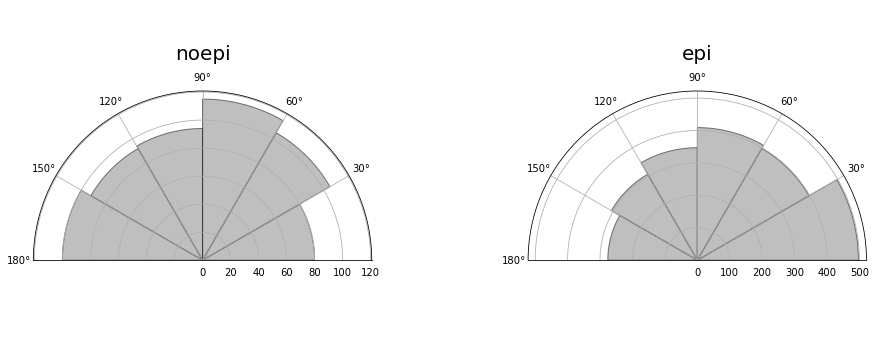

In [43]:
# #Compute pie slices
# N = 6
# theta = np.linspace(0.0, np.pi, N, endpoint=False)
# theta = theta+(theta[1]/2)
# noepihist, bins = np.histogram(abs(noepi.angle), bins=6, range=(0,180))
# radii = noepihist
# width = np.pi / 6
# colors = plt.cm.viridis(radii / 10.)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(projection='polar')
# ax.bar(theta, noepihist, width=width, bottom=0.0, alpha=0.5)
# # ax.set_thetamin(0)
# ax.set_thetamax(180)

# epihist, bins = np.histogram(abs(epi.angle), bins=6, range=(0,180))
# radii = epihist

# ax2 = fig.add_subplot(projection='polar')
# ax2.bar(theta, radii, width=width, bottom=0.0, alpha=0.5)
# # ax.set_thetamin(0)
# ax2.set_thetamax(180)

# plt.show()

N = 6
theta = np.linspace(0.0, np.pi, N, endpoint=False)
width = np.pi / 6
fig, axes = plt.subplots(1,2,figsize=(15,5), subplot_kw={'projection': 'polar'})
for i, ax in enumerate(axes):
    temp = newest[newest.treatment == newest.treatment.unique()[i]]
    hist, bins = np.histogram(abs(temp.angle), bins=N, range=(0,180))
    ax.bar(theta, hist, width=width, align = 'edge', bottom=0.0, alpha=0.5, color = 'gray', edgecolor = 'black')
    ax.set_thetamax(180)
    ax.set_xticks(np.pi/180 * np.linspace(180, 0, 6, endpoint=False))
    ax.set_title(newest.treatment.unique()[i], y=.825)
    ax.title.set_fontsize(20)
plt.tight_layout()
fig.savefig("F:/caged_FITC/Data/20220623_angle_polar_plot.png") 

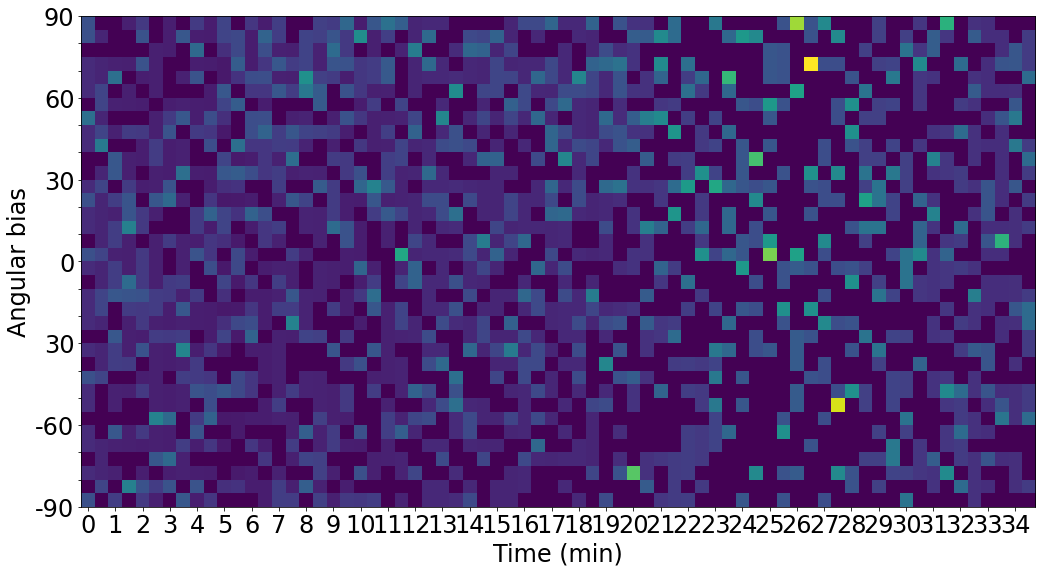

In [415]:
#Data from 20220623

import matplotlib.pyplot as plt
df = pd.read_csv('F:/caged_FITC/Data/20220623_Total_Tracking_Data.csv')
df['cellid'] = df.image + ' cell ' + df.cell.astype(str)
collected = df[df.euclid >20]

def signed_3D_angle_relative_to_X(Va):
    Vb = np.array([1,0,0])
    cr = np.cross(Va,Vb)
    Vn = cr/np.linalg.norm(cr)
    radians = math.atan2(np.dot(np.cross(Va, Vb), Vn), np.dot(Va, Vb))
    angle = math.degrees(radians)
    if Va[1] < 0:
        angle = -angle
    return angle


def Angular_bias(Va):
    M2 = Va[1]/Va[0]
    angle = math.degrees(math.atan2(Va[1],Va[0]))
    bias = 90 - abs(angle)
    return bias, angle

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def vec_angle(
    vector_1,
    vector_2):
    
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    degree = math.degrees(angle)
    return degree

newdf = pd.DataFrame([])
for i, x in collected.groupby('cellid'):
    x = x.reset_index(drop = True)
    dif = x[['x','y','z']].diff()
    bias = []
    angle = []
    for r in range(len(x)):
        if r == 0:
            bias.append(np.nan)
            angle.append(np.nan)
        else:
            b, a = Angular_bias(dif.iloc[r][['x','y']])
            bias.append(b)
            angle.append(a)
    x['angular_bias'] = bias
    x['angle'] = angle
    newdf = newdf.append(x)
newdf = newdf.reset_index(drop = True)




#create histograms for heat map
binnum = 36
noNA_frame = newdf.dropna()
angleheatmap = np.empty([binnum,
                        len(noNA_frame.dropna().frame.unique())])
                        

for i, x in enumerate(noNA_frame.frame.sort_values().unique()):
    temp = noNA_frame[noNA_frame.frame == x]
    hist, bins = np.histogram(temp.angular_bias, bins=binnum, range=(-90,90))
    angleheatmap[:,i] = hist[::-1]/hist.sum()
        
#plot histograms
fig, ax = plt.subplots(figsize=(15, 10))

ax.imshow(angleheatmap)
# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(angleheatmap.shape[-1], step=2))
ax.set_xticklabels(list(range(math.ceil(angleheatmap.shape[-1]/2))))
ax.set_yticks(np.arange(-0.5,len(bins)+0.5,step=2))
ax.set_yticklabels([90,'','',60,'','',30,'','',0,'','',30,'','',-60,'','',-90])
ax.set_xlabel('Time (min)')
ax.set_ylabel('Angular bias')
#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
#     for i in range(len(vegetables)):
#         for j in range(len(farmers)):
#             text = ax.text(j, i, harvest[i, j],
#                            ha="center", va="center", color="w")


plt.tight_layout()

# plt.savefig("F:/caged_FITC/Data/20220510_0525_angular bias histogram.png") 

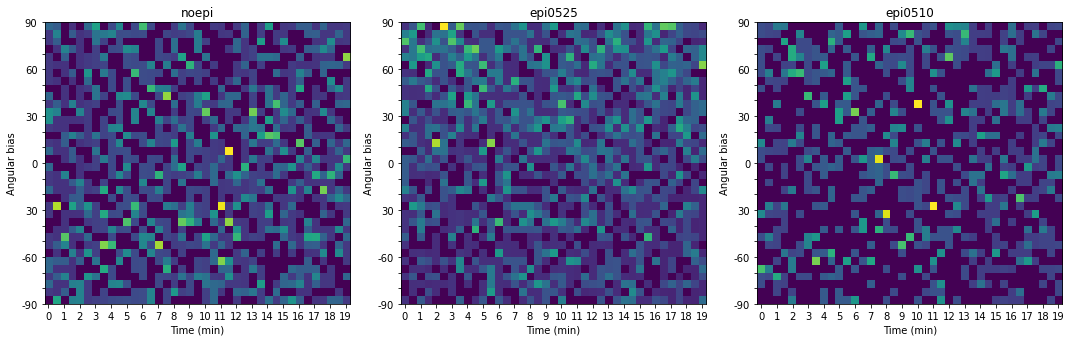

In [318]:
#create histograms for heat map
binnum = 36
noNA_frame = newest.dropna()
angleheatmap = np.empty([len(noNA_frame.dropna().treatment.unique()),
                        binnum,
                        len(noNA_frame.dropna().frame.unique())])
                        
for t in range(angleheatmap.shape[0]):
    temp_treat = noNA_frame[noNA_frame.treatment == noNA_frame.treatment.unique()[t]]
    for i, x in enumerate(noNA_frame.frame.sort_values().unique()):
        temp = temp_treat[temp_treat.frame == x]
        hist, bins = np.histogram(temp.angles, bins=binnum, range=(-90,90))
        angleheatmap[t,:,i] = hist[::-1]/hist.sum()
        
#plot histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ax.imshow(angleheatmap[i,:,:])
    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(angleheatmap.shape[2], step=2))
    ax.set_xticklabels(list(range(math.ceil(angleheatmap.shape[2]/2))))
    ax.set_yticks(np.arange(-0.5,len(bins)+0.5,step=2))
    ax.set_yticklabels([90,'','',60,'','',30,'','',0,'','',30,'','',-60,'','',-90])
    ax.title.set_text(noNA_frame.treatment.unique()[i])
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Angular bias')
#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
#     for i in range(len(vegetables)):
#         for j in range(len(farmers)):
#             text = ax.text(j, i, harvest[i, j],
#                            ha="center", va="center", color="w")


plt.tight_layout()

plt.savefig("F:/caged_FITC/Data/20220510_0525_angular bias histogram.png") 

IndexError: index 2 is out of bounds for axis 0 with size 2

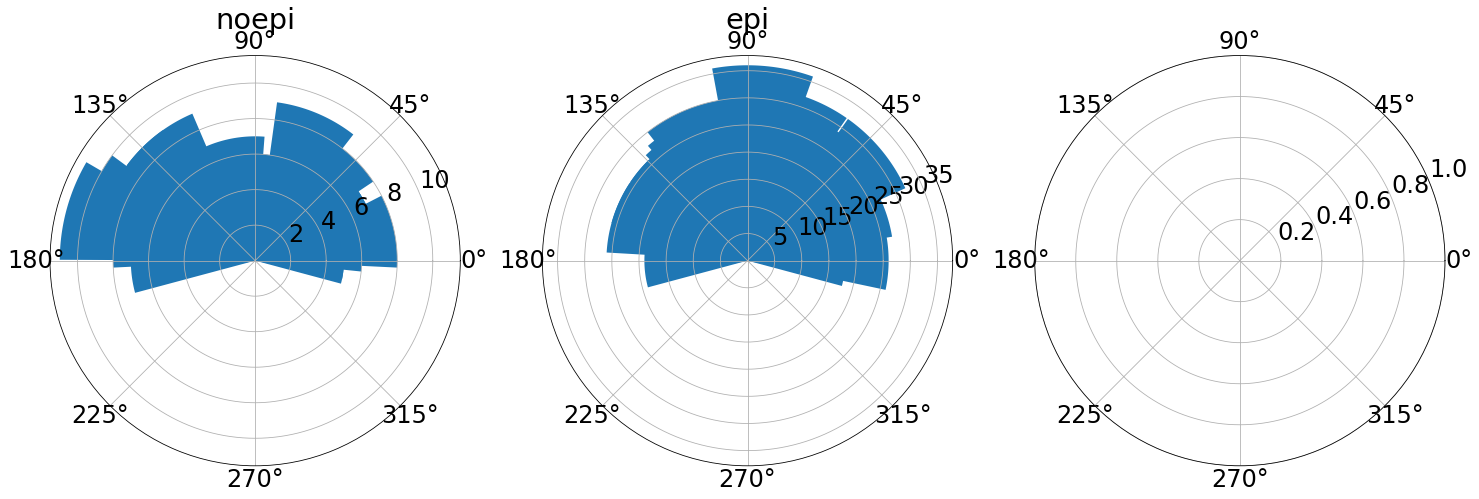

In [430]:
# Compute pie slices
N = 60
theta = np.linspace(0.0, np.pi, N, endpoint=True)
radii = 10 * np.random.rand(N)
width = np.pi / 4 * np.random.rand(N)

f, axes = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize = (25,10))
for i, ax in enumerate(axes):
    hist, bins = np.histogram(newest[newest.treatment == newest.treatment.unique()[i]].angles, bins = 60, range = (-90,90))
    radii = hist
    ax.bar(theta, radii, width=width, bottom=0.0)
    ax.title.set_text(newest.treatment.unique()[i])
#     bar.set_alpha(0.5)
    
# # Use custom colors and opacity
# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.viridis(r / 10.))
#     bar.set_alpha(0.5)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)


plt.tight_layout()

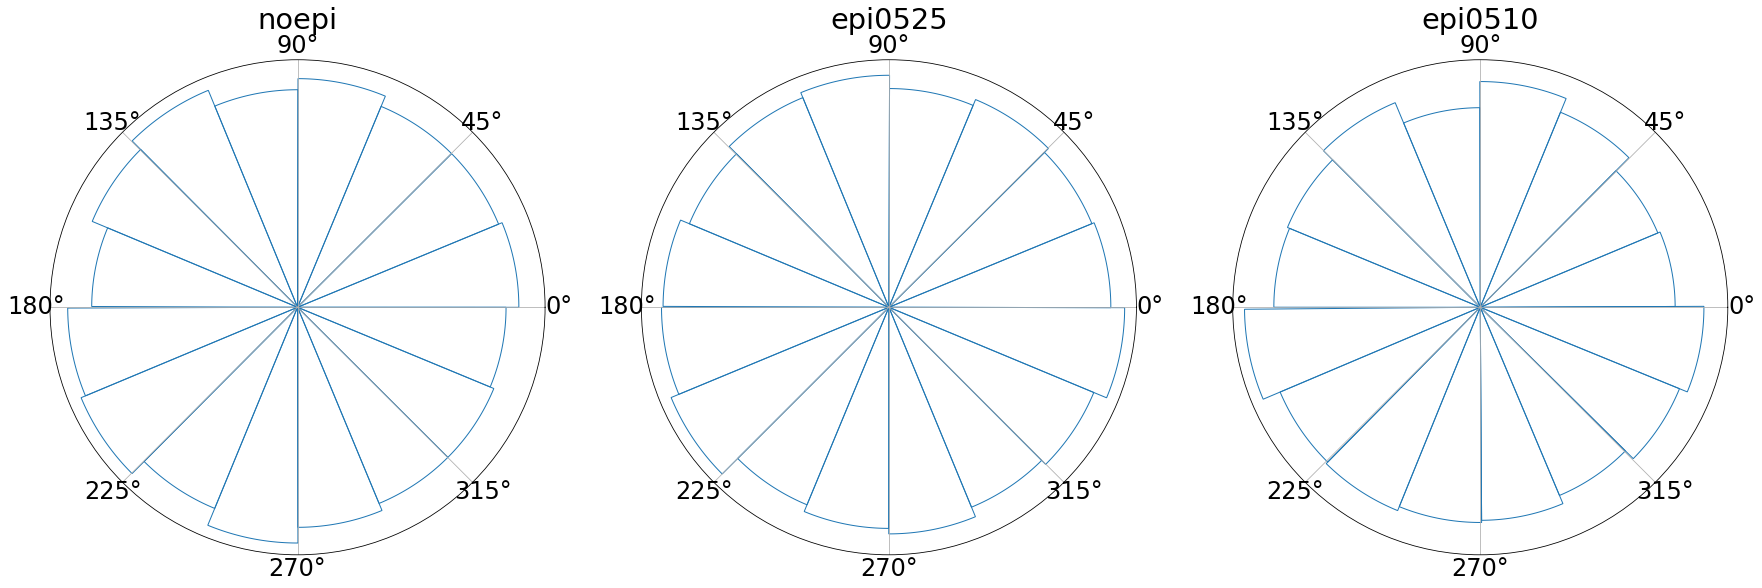

In [330]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

    return n, bins, patches

noNA_frame = newest.dropna()

f, axes = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize = (25,10))
for i, ax in enumerate(axes):
    circular_hist(ax, noNA_frame[noNA_frame.treatment == noNA_frame.treatment.unique()[i]].angle)
    ax.title.set_text(noNA_frame.treatment.unique()[i])
#     bar.set_alpha(0.5)
    
# # Use custom colors and opacity
# for r, bar in zip(radii, bars):
#     bar.set_facecolor(plt.cm.viridis(r / 10.))
#     bar.set_alpha(0.5)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 24}

plt.rc('font', **font)


plt.tight_layout()

In [35]:
widths

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3.])

In [21]:
newest.treatment.unique()[0]

'noepi'

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


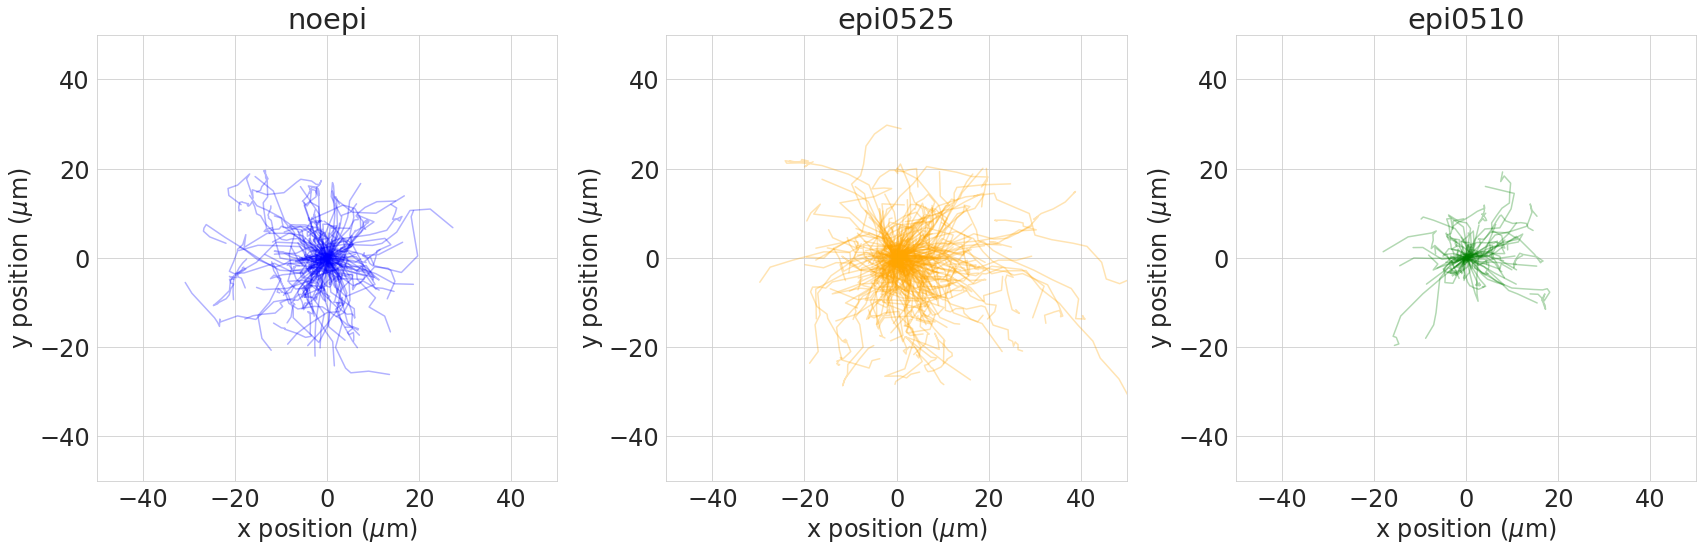

In [412]:
import matplotlib.pyplot as plt
import re
###################################################
########### figure of absolute trajectories #######
###################################################

# f = plt.figure(figsize=(6,6))
# ax = plt.axes()
f, axes = plt.subplots(1, 3, figsize=(24,8))

for i in newest.cellid.unique():
    _df_track = newest[newest.cellid==i]
    if _df_track.treatment.iloc[0] == 'noepi':
        color = 'blue'
        axes[0].plot(_df_track.x - _df_track.x.iloc[0], 
               _df_track.y - _df_track.y.iloc[0], color = color, alpha = 0.3)
    elif _df_track.treatment.iloc[0] == 'epi0525': 
        color = 'orange'
        axes[1].plot(_df_track.x - _df_track.x.iloc[0], 
                       _df_track.y - _df_track.y.iloc[0], color = color, alpha = 0.3)
    elif _df_track.treatment.iloc[0] == 'epi0510': 
        color = 'green'
        axes[2].plot(_df_track.x - _df_track.x.iloc[0], 
                       _df_track.y - _df_track.y.iloc[0], color = color, alpha = 0.3)
axes[0].set_xlabel('x position ($\mu$m)')
axes[0].set_ylabel('y position ($\mu$m)')
axes[1].set_xlabel('x position ($\mu$m)')
axes[1].set_ylabel('y position ($\mu$m)')
axes[2].set_xlabel('x position ($\mu$m)')
axes[2].set_ylabel('y position ($\mu$m)')
axes[0].set_xlim(-50,50)
axes[0].set_ylim(-50,50)
axes[1].set_xlim(-50,50)
axes[1].set_ylim(-50,50)
axes[2].set_xlim(-50,50)
axes[2].set_ylim(-50,50)
axes[0].title.set_text('noepi')
axes[1].title.set_text('epi0525')
axes[2].title.set_text('epi0510')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

plt.tight_layout()
plt.savefig('F:/caged_FITC/Data/caax_trajectories.png')

In [351]:
collected.euclid.min()

10.13491118191592

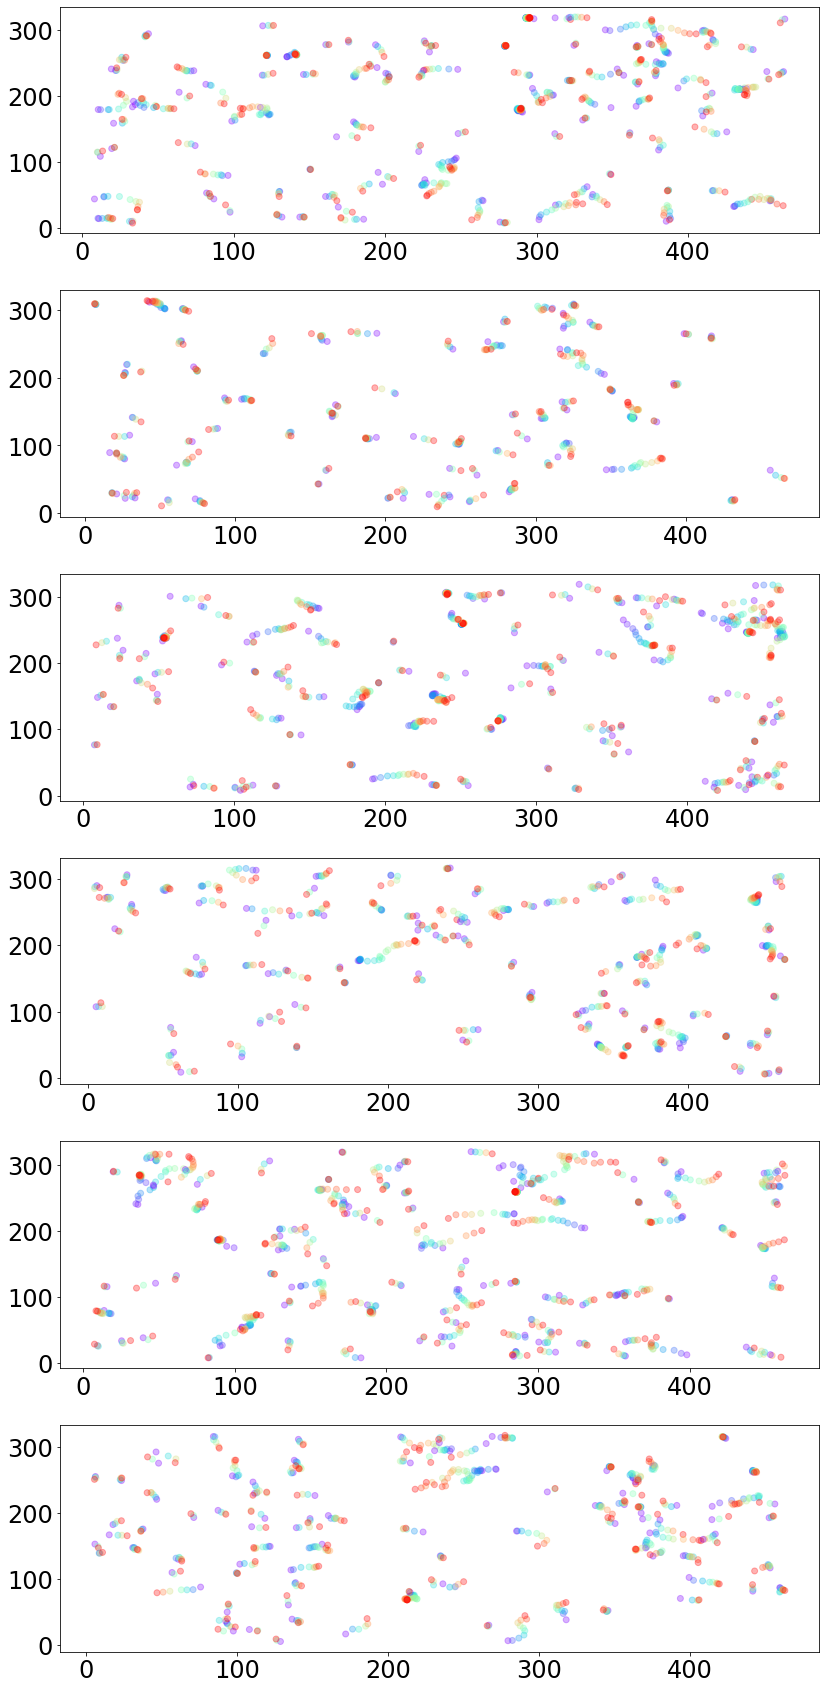

In [353]:
###################################################
########### figure of actual trajectories #######
###################################################

import matplotlib.pyplot as plt
import re
df_track = collected.copy()
df_track['cellid'] = df_track.image + ' cell ' + df_track.cell.astype(str)
num_cells = len(morethanthreeframes.cell.unique())


# f = plt.figure(figsize=(6,6))
# ax = plt.axes()
f, axes = plt.subplots(6, 1, figsize=(12,24))
for x, ax in enumerate(axes):
    image = df_track[df_track.image == collected.image.unique()[x]]
    
    for i in image.cellid.unique():
        cell = image[image.cellid==i]
        ax.scatter(cell.x, cell.y, c=cell.frame, cmap = 'rainbow' ,alpha = 0.3)

        
        
# ax1.set_xlabel('x position ($\mu$m)')
# ax1.set_ylabel('y position ($\mu$m)')
# ax1.set_xlim(-20,20)
# ax1.set_ylim(-20,20)
# ax2.set_xlim(-20,20)
# ax2.set_ylim(-20,20)

plt.tight_layout()
# plt.savefig('DoesntLookGreat.png')

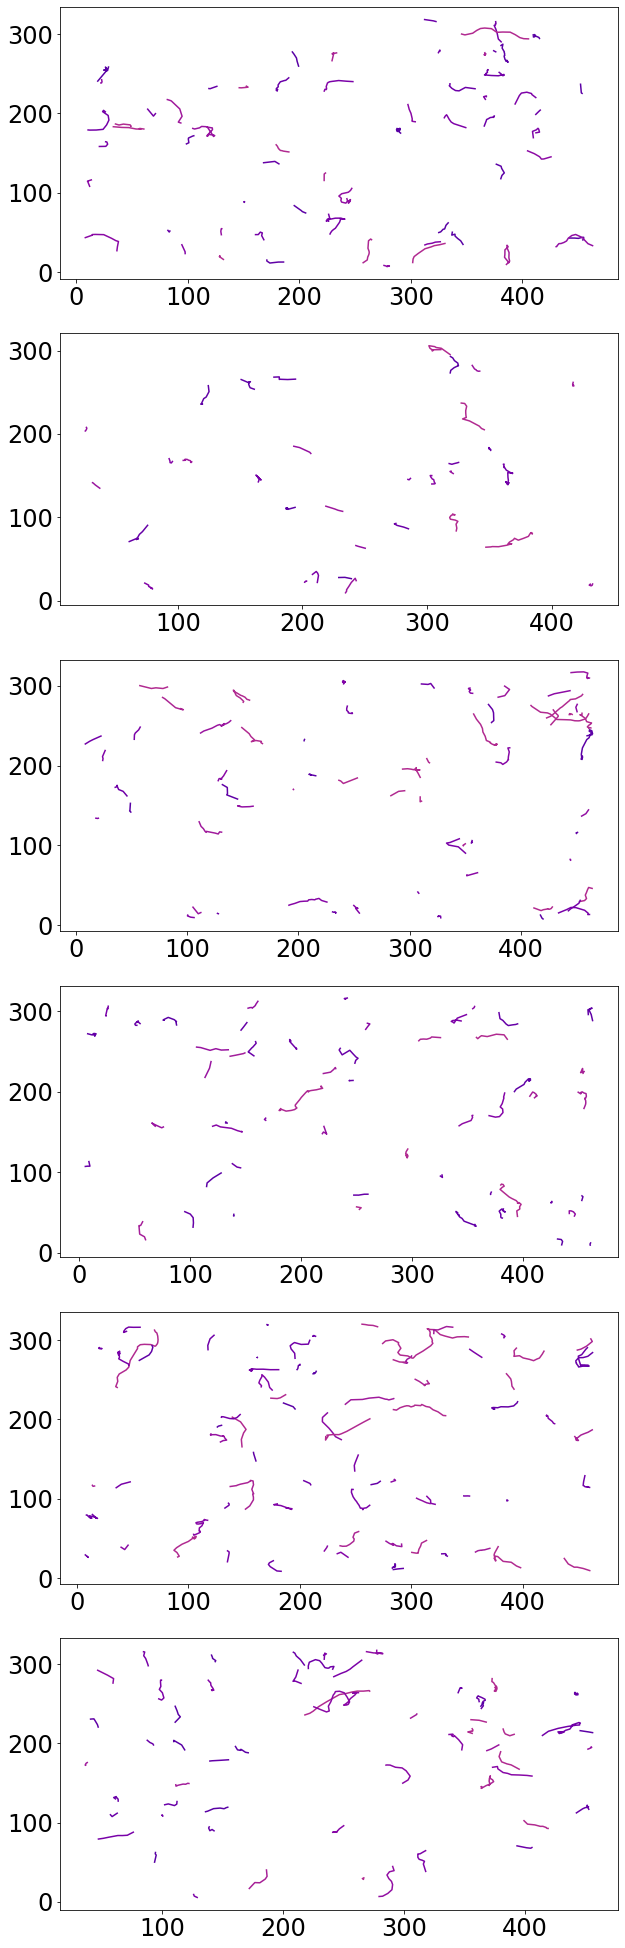

In [416]:
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re
df_track = collected.copy()
df_track['cellid'] = df_track.image + ' cell ' + df_track.cell.astype(str)
num_cells = len(morethanthreeframes.cell.unique())

plasma = cm.get_cmap('plasma')
newcmp = ListedColormap(plasma(list(range(math.floor(df_track.euclid.min()), math.ceil(df_track.euclid.max()),2))))

# f = plt.figure(figsize=(6,6))
# ax = plt.axes()
f, axes = plt.subplots(6, 1, figsize=(10,35))
for x, ax in enumerate(axes):
    image = df_track[df_track.image == collected.image.unique()[x]]
    
    for i in image.cellid.unique():
        cell = image[image.cellid==i]
        ax.plot(cell.x, cell.y,c=newcmp(math.floor(cell.euclid.reset_index(drop=True)[0])-10))
#         print(math.floor(cell.euclid.reset_index(drop=True)[0])-10)


# plasma = cm.get_cmap('plasma')
# newcmp = ListedColormap(plasma(np.linspace(0.25, 0.75, 256)))
# newcmp(.25)

In [411]:
# np.linspace(math.floor(df_track.euclid.min()), math.ceil(df_track.euclid.max()), step = 1)
# list(range(math.floor(df_track.euclid.min()), math.ceil(df_track.euclid.max()),2))
newcmp(5), newcmp(0), plasma(list(range(math.floor(df_track.euclid.min()), math.ceil(df_track.euclid.max()),2)))

((0.221197, 0.016497, 0.602083, 1.0),
 (0.148607, 0.021154, 0.570562, 1.0),
 array([[1.48607e-01, 2.11540e-02, 5.70562e-01, 1.00000e+00],
        [1.64070e-01, 2.01710e-02, 5.77478e-01, 1.00000e+00],
        [1.78950e-01, 1.92520e-02, 5.84054e-01, 1.00000e+00],
        [1.93374e-01, 1.83540e-02, 5.90330e-01, 1.00000e+00],
        [2.07435e-01, 1.74420e-02, 5.96333e-01, 1.00000e+00],
        [2.21197e-01, 1.64970e-02, 6.02083e-01, 1.00000e+00],
        [2.34715e-01, 1.55020e-02, 6.07592e-01, 1.00000e+00],
        [2.48032e-01, 1.44390e-02, 6.12868e-01, 1.00000e+00],
        [2.61183e-01, 1.33080e-02, 6.17911e-01, 1.00000e+00],
        [2.74191e-01, 1.21090e-02, 6.22722e-01, 1.00000e+00],
        [2.87076e-01, 1.08550e-02, 6.27295e-01, 1.00000e+00],
        [2.99855e-01, 9.56100e-03, 6.31624e-01, 1.00000e+00],
        [3.12543e-01, 8.23900e-03, 6.35700e-01, 1.00000e+00],
        [3.25150e-01, 6.91500e-03, 6.39512e-01, 1.00000e+00],
        [3.37683e-01, 5.61800e-03, 6.43049e-01, 1.00000e

In [124]:
df_track[df_track.image == collected.image.unique()[0]]

,cell,SPOT_ID,frame,x,y,z,z_min,y_min,x_min,z_max,...,z_range,solidity,area,convex_area,extent,minor_axis_length,major_axis_length,dist,image,cellid
0,0,147,1.0,123.644198,20.072243,11.781986,9.0,85.0,726.0,40.0,...,90.0,0.918938,104849.0,114098.0,0.474099,30.050309,90.963529,3.578591,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
1,0,135,2.0,124.534597,19.778641,11.203695,5.0,78.0,730.0,40.0,...,90.0,0.890949,114544.0,128564.0,0.422664,32.132424,92.574493,1.101559,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
2,0,141,3.0,126.034323,19.156454,11.424571,4.0,60.0,735.0,40.0,...,90.0,0.812709,112344.0,138234.0,0.315857,30.371398,114.037935,1.638622,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
3,0,145,4.0,127.119578,18.272716,11.156924,3.0,57.0,740.0,40.0,...,90.0,0.773985,111162.0,143623.0,0.297522,29.403440,121.942124,1.424923,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
4,0,143,5.0,128.426950,17.582919,10.813422,1.0,52.0,745.0,40.0,...,90.0,0.669164,118414.0,176958.0,0.272946,30.302732,132.732505,1.517576,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,78,274,1.0,36.310360,22.319696,24.089929,35.0,109.0,161.0,64.0,...,90.0,0.623064,64484.0,103495.0,0.268549,19.910848,155.868543,2.449595,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
285,78,236,2.0,30.742444,20.261745,25.442990,38.0,85.0,150.0,72.0,...,90.0,0.694612,51386.0,73978.0,0.238534,22.262179,93.974194,6.088319,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
286,78,237,3.0,29.173199,19.576638,25.698991,35.0,81.0,148.0,73.0,...,90.0,0.653118,55598.0,85127.0,0.282726,29.131159,86.593426,1.731311,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...
287,78,224,4.0,30.167279,20.904358,26.420350,40.0,85.0,142.0,71.0,...,90.0,0.520498,40069.0,76982.0,0.197125,26.328821,81.201055,1.808699,20220510_squareaperture0_10sepi50preactivation...,20220510_squareaperture0_10sepi50preactivation...


In [23]:
keylist = [x for x in list(mem_feat) if not x.endswith('lcc')]
mem_feat[keylist[0]]

1428.7508674714759